# Content-Based

Source 1: https://itnext.io/what-are-the-top-recommendation-engine-algorithms-used-nowadays-646f588ce639

Source 2: https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243

We have seen in the previous notebook what that the collaborative filtering methods suffer from the cold-start problem, which is that there is no efficient method to update the embeddings after adding a new item or a new user. Indeed, because these methods are computed using exclusively the feedbacks, they can’t recommend items with no history, meaning with no previous feedbacks frol users.

In order to overcome this problem, the content based methods offer an approach similar to User-User and Item-Item methods, except that the similarities between users (or items) are computed using only content-based features.

The main constraints with the content based methods is that they recquire a dataset including detailed descriptions of the items/users. Because the dataset **goodbooks-10k** does not provide such details on the items/users, we will be working on this notebook with the **MovieLens-100k** dataset.

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.metrics import roc_auc_score

Dataset: **ml-100k**

In [2]:
path_ml = "/Users/stanislasbucaille/Desktop/data_bases/data_movieLens/ml-100k/"

users = pd.read_csv(path_ml + 'u.user', delimiter='|', header=None, names=['id','age','gender','occupation','zip code'])
items = pd.read_csv(path_ml + 'u.item', delimiter='|', encoding='latin-1', header=None, names=['movieId','title','date','N','url',*[f'g{i}' for i in range(19)]])
occupations = pd.read_csv(path_ml + 'u.occupation', delimiter='\n', header=None).values

train = pd.read_csv(path_ml + 'ua.base', delimiter='\t', header=None, names=['userId','movieId','rating','timestemp'])
test = pd.read_csv(path_ml + 'ua.test', delimiter='\t', header=None, names=['userId','movieId','rating','timestemp'])

In [3]:
dic_test = {}

for l in range(len(test)):
    line = test.loc[l]
    u, i, r, t = line[0], line[1], line[2], line[3]
    
    # Ratings
    dic_test[(i, u)] = r

## 1. Users content

In [4]:
users.head(2)

,id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043


Data processing

In [5]:
users.isnull().sum(axis = 0)

id            0
age           0
gender        0
occupation    0
zip code      0
dtype: int64

In [6]:
# Zip code
new_users = users.drop(['zip code'], axis=1)

# Gender
new_users = new_users.replace({'M':0, 'F':1})

# Occupation
for i in range(len(occupations)):
    occ = occupations[i][0]
    new_users[occ] = np.zeros(len(users))
    ids_occ = new_users.loc[users['occupation'] == occ]['id']-1
    new_users.loc[ids_occ, occ] = 1
new_users = new_users.drop(['id', 'occupation'], axis=1)

# map age
df_age = []
for age in users['age']:
    if age <= 25:
        df_age.append([0])
    elif 25 < age <= 50:
        df_age.append([1])
    elif 50 < age:
        df_age.append([2])
        
new_users['age'] = pd.DataFrame(df_age)

In [7]:
new_users.head(2)

,age,gender,administrator,artist,doctor,educator,engineer,entertainment,executive,healthcare,...,marketing,none,other,programmer,retired,salesman,scientist,student,technician,writer
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Apply k-means to construct clusters

In [8]:
from sklearn.cluster import KMeans

def create_clusters(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)

    dic_clusters = {}
    for id in range(1, len(data)):
        id_cluster = kmeans.labels_[id]
        if id_cluster not in dic_clusters:
            dic_clusters[id_cluster] = [id+1]
        else:
            dic_clusters[id_cluster].append(id+1)
    
    return dic_clusters, kmeans

In [9]:
import matplotlib.pyplot as plt

dic_clusters, kmeans = create_clusters(new_users, 1)
keys = []
nb_users = []

for key in dic_clusters:
    keys.append(key)
    nb_users.append(len(dic_clusters[key]))

plt.figure()
plt.bar(keys, nb_users)
plt.title("Number of users per cluster")
plt.show()

<Figure size 640x480 with 1 Axes>

We can see that the users are nicely distributed between the different clusters.

In [10]:
def prediction_users(u, i, dic_clusters, kmeans):
    cluster_id = kmeans.labels_[u]
    cluster = dic_clusters[cluster_id]

    n = len(cluster)
    r = 0
    for user in cluster:
        try:
            #if dic_test[(i, user)] >= 4: r += 1
            r += dic_test[(i, user)]
        except:
            n -= 1
    try:
        #return round(r/n)
        return r/n
    except:
        return('problem of sparcity')

In [11]:
scores = []
i = 0
j = 0
for u, df_u  in test.groupby(['userId']):
    # items in the test set
    ind = list(df_u['movieId']-1)
    ratings = np.array(df_u['rating'] >= 4)

    predicted = []
    expected = []
    # Prediction
    for k in range(len(ind)):
        try : 
            i  = ind[k]
            r = ratings[k]
            y_predicted = prediction_users(u, i, dic_clusters, kmeans)
            if type(y_predicted) != str:
                predicted.append(y_predicted)
                if r:expected.append(1)
                else: expected.append(0)
        except:
            #print("error 1")
            continue
    try:
        score =  roc_auc_score(expected,predicted)
        scores.append(score)
    except:
        #print("error 2")
        continue


In [12]:
np.mean(scores)

0.5556338928213929

In [13]:
n = len(test)
prediction = []
rating = []

error1 = 0
error2 = 0
for j in range(1,n):
    line = test.loc[j]
    u, i, r, t = line[0], line[1], line[2], line[3]

    try: 
        r_pred = prediction_users(u, i, dic_clusters, kmeans)
        
        error1 += abs(r-r_pred)
        if int(r) != int(r_pred):
            error2 += 1
        prediction.append(float(r_pred))
        if r >= 4:
            rating.append(1)
        else:
            rating.append(0)
    except:
        n -= 1
        
print(error1/n)        
print(error2/n)

print('Number of unrated samples because of sparcity problem : ' + str(len(test)-n) + ' on ' + str(len(test)))

0.7547368663170462
0.6597664543524416
Number of unrated samples because of sparcity problem : 10 on 9430


In [14]:
#prediction, rating

In [15]:
from sklearn.metrics import roc_auc_score
roc_auc_score(rating,prediction)

0.746825520190006

## 2. Items content

In [53]:
items.head(2)

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


Data processing

In [54]:
#items.isnull().sum(axis = 0)

In [55]:
# Drop columns
new_items = items.drop(['movieId', 'title', 'N', 'url'], axis=1)

# Date
new_items['day'] = np.zeros(len(new_items))
new_items['month'] = np.zeros(len(new_items))
new_items['year'] = np.zeros(len(new_items))

dic_months = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

for i in range(len(new_items)):
    if i == 266: 
        continue
    else:
        date = new_items.loc[i,'date']
        day, month, year = date.split('-')
        month = dic_months[month]
    
        new_items.loc[i,'day'] = int(day)
        new_items.loc[i,'month'] = int(month)
        new_items.loc[i,'year'] = int(year)
new_items = new_items.dropna(subset=['date'])
new_items = new_items.drop(['date'], axis=1)

In [56]:
new_items.head(2)

,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,...,g12,g13,g14,g15,g16,g17,g18,day,month,year
0,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1.0,1.0,1995.0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1.0,1.0,1995.0


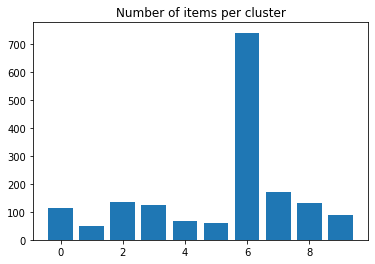

In [57]:
import matplotlib.pyplot as plt

dic_clusters, kmeans = create_clusters(new_items, 10)
keys = []
nb_items = []

for key in dic_clusters:
    keys.append(key)
    nb_items.append(len(dic_clusters[key]))

plt.figure()
plt.bar(keys, nb_items)
plt.title("Number of items per cluster")
plt.show()

We can see that a majority of movies is concentrated in a single cluster. 

In [58]:
def prediction_items(u, i, dic_clusters, kmeans):
    cluster_id = kmeans.labels_[i]
    cluster = dic_clusters[cluster_id]

    n = len(cluster)
    r = 0
    for item in cluster:
        try:
            r += dic_test[(item, u)]
        except:
            n -= 1
    try:
        return round(r/n)
    except:
        return('problem of sparcity')

In [59]:
n = len(test)

dic_clusters, kmeans = create_clusters(new_items, 10)
error1 = 0
error2 = 0
for i in range(1,n):
    line = test.loc[i]
    u, i, r, t = line[0], line[1], line[2], line[3]

    try: 
        r_pred = prediction_items(u, i, dic_clusters, kmeans)
        error1 += abs(r-r_pred)
        if int(r) != int(r_pred):
            error2 += 1
    except:
        n -= 1
        
print(error1/n)        
print(error2/n)

print('Number of unrated samples because of sparcity problem : ' + str(len(test)-n) + ' on ' + str(len(test)))

0.7838632113278119
0.5810846914239914
Number of unrated samples because of sparcity problem : 1944 on 9430


In [60]:
n = len(test)
prediction = []
rating = []

error1 = 0
error2 = 0
for j in range(1,n):
    line = test.loc[j]
    u, i, r, t = line[0], line[1], line[2], line[3]

    try: 
        r_pred = prediction_items(u, i, dic_clusters, kmeans)
        
        error1 += abs(r-r_pred)
        if int(r) != int(r_pred):
            error2 += 1
        prediction.append(float(r_pred))
        if r >= 4:
            rating.append(1)
        else:
            rating.append(0)
    except:
        n -= 1
        
print(error1/n)        
print(error2/n)

print('Number of unrated samples because of sparcity problem : ' + str(len(test)-n) + ' on ' + str(len(test)))

0.7838632113278119
0.5810846914239914
Number of unrated samples because of sparcity problem : 1944 on 9430


In [61]:
from sklearn.metrics import roc_auc_score
roc_auc_score(rating,prediction)

0.6829288725317978

## Results

**error1** : average distance between the actual rating and the predicted one

**error2** : percentage of correctly predicted ratings

User - Content base method:
- error1 = 0.8857306919322423
- error2 = 0.6415446454206144

Item - Content base method:
- error1 = 0.7838632113278119
- error2 = 0.5810846914239914

## Conclusion

We can see that the method based on items content perfoms better than the method based on users content. Furtheremore, we can notice that a nice distribution of items/users in the clusters does not necessarily imply a better performance.

Finally, even though these methods are a solution to the cold-start problem, they do not seam to perfom as well as the Latent Factorization method.

Thus, in order to construct an efficent method for recommander systems, we can think of an **hybrid method**, which is the goal of my next notebook.